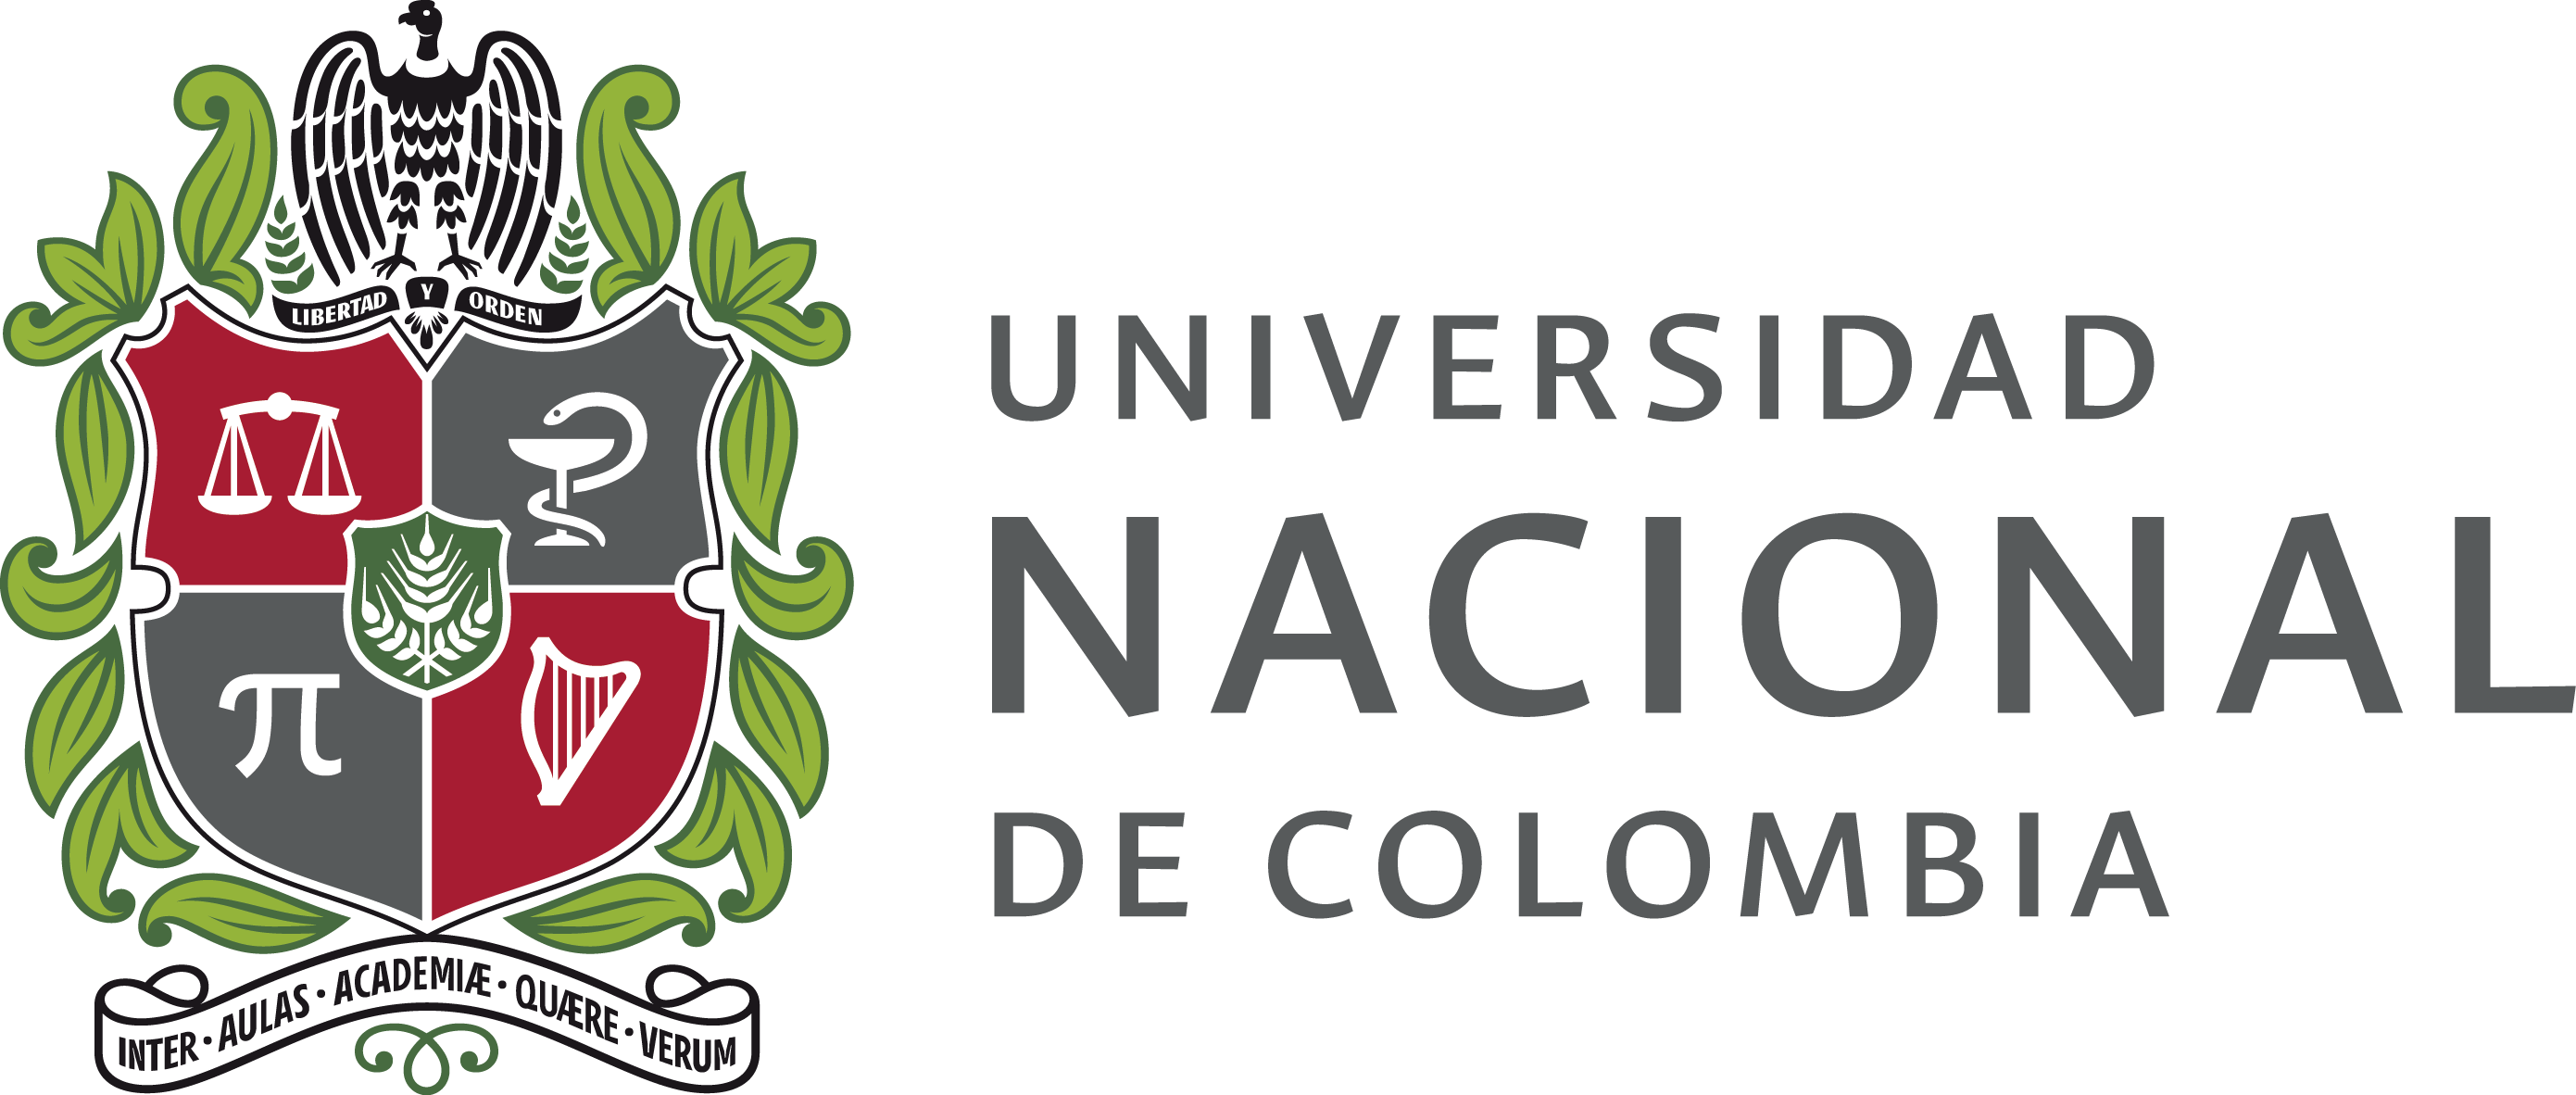
### **Universidad Nacional de Colombia sede Manizales**
#### Facultad de ingeniería y arquitectura
#### Departamento de ingeniería eléctrica, electrónica y computación
#### *Procesamiento digital de imágenes*

#### Profesor: Lucas Iturriago

## Perceptrón y MLP

### 9.1 Motivación

Antes del auge del aprendizaje profundo, los sistemas de visión por computador se basaban en **métodos manuales** para extraer características y clasificar imágenes.

**Ejemplos de técnicas clásicas:**

* **Filtrado espacial:** detección de bordes (Sobel, Canny).
* **Análisis de textura:** Haralick, LBP.
* **Descriptores locales:** SIFT, SURF, HOG.
* **Clasificadores tradicionales:** k-NN, SVM, Árboles de decisión.

Estos enfoques funcionaban bien **solo si el ingeniero diseñaba las características adecuadas** (“feature engineering”), lo cual requería mucho conocimiento del dominio.

#### **Transición al aprendizaje automático**

| Tipo de limitación                      | Descripción                                                                                            |
| --------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **Dependencia del diseño manual**       | Se necesitaban descriptores específicos para cada problema.                                            |
| **Pérdida de información espacial**     | Al vectorizar una imagen, se ignora la estructura local (patrones y relaciones espaciales).            |
| **Escalabilidad limitada**              | Al aumentar la complejidad de los datos, los modelos clásicos no podían capturar patrones no lineales. |
| **Sensibilidad al ruido y variaciones** | Cambios de iluminación, rotación o escala afectaban el rendimiento.                                    |

#### **Transición al aprendizaje automático**

La idea fue **permitir que el modelo aprenda las características directamente de los datos**, en lugar de diseñarlas manualmente.

El **Perceptrón** fue uno de los primeros modelos que formalizó esta idea: una neurona artificial que aprende los pesos que mejor separan las clases.

#### **Intuición visual**

Imagina un conjunto de puntos en el plano (2D) que pertenecen a dos clases (azul y rojo).
El perceptrón busca una **línea (hiperplano)** que las separe:

$$
w_1 x_1 + w_2 x_2 + b = 0
$$

Donde los **pesos** ( $w_1$, $w_2$ ) y el **sesgo** ( $b$ ) determinan la orientación y posición de la frontera de decisión.

#### **De la neurona al cerebro artificial**

Una sola neurona puede resolver problemas simples (como clasificar puntos linealmente separables).
Pero al **conectar muchas neuronas en capas**, surge la capacidad de aprender funciones complejas → ahí nace el **Perceptrón Multicapa (MLP)**.

#### **Visualizar la limitación de un método clásico**

### 9.2 El perceptrón simple

#### **Formulación matemática**

Sea una entrada $\mathbf{x} \in \mathbb{R}^n$ (a la que podemos añadir una componente constante para el sesgo) y pesos $\mathbf{w} \in \mathbb{R}^n$ y sesgo $b \in \mathbb{R}$.

#### **Net input (actividad lineal)**

$$
z = \mathbf{w}^\top \mathbf{x} + b = \sum_{i=1}^{n} w_i x_i + b
$$

#### **Función de activación (función escalón / signo)**

El perceptrón clásico usa la función escalón (o signo) para producir la salida discreta $\hat{y} \in {-1, +1}$:

$$
\hat{y} = \text{sign}(z) =
\begin{cases}
+1 & \text{si } z \ge 0,[4pt]
-1 & \text{si } z < 0.
\end{cases}
$$

(En implementaciones se usa a veces $\hat{y} \in {0,1}$; aquí usaremos ({-1,+1}) porque la regla de actualización queda más limpia.)

#### **Regla de aprendizaje (Perceptron learning rule)**

Para una muestra $(\mathbf{x}^{(t)}, y^{(t)})$ con $y^{(t)} \in \{-1,+1\}$, si la predicción está correcta $(y^{(t)} \hat{y}^{(t)} > 0)$, no hay actualización. Si está mal clasificada $(y^{(t)} \hat{y}^{(t)} \le 0)$, actualizamos:

$$
\mathbf{w} \leftarrow \mathbf{w} + \eta , y^{(t)} \mathbf{x}^{(t)}
$$
$$
b \leftarrow b + \eta , y^{(t)}
$$

donde $\eta > 0$ es la **tasa de aprendizaje**.
Intuición: si la muestra pertenece a la clase +1 pero fue clasificada como -1, sumamos $\eta$ $\mathbf{x}$ para mover el hiperplano hacia la muestra; análogamente para la clase -1.

#### **Implementación en NumPy de un Perceptrón**

In [ ]:
# @title
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import Image
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation, PillowWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [3]:
# 1. Generación de datos sintéticos

np.random.seed(42)

def make_linear_separable(n_samples=200, noise=0.3):
    # Clase +1
    X_pos = np.random.randn(n_samples//2, 2) * 0.8 + np.array([2.0, 1.8])
    # Clase -1
    X_neg = np.random.randn(n_samples//2, 2) * 0.8 + np.array([-1.8, -1.5])
    # Añadimos algo de ruido
    X = np.vstack([X_pos, X_neg]) + np.random.normal(0, noise, (n_samples, 2))
    y = np.hstack([np.ones(n_samples//2), -np.ones(n_samples//2)])
    return X, y

X, y = make_linear_separable(200, noise=0.2)

In [4]:
# 2. Clase Perceptrón

class Perceptron:
    def __init__(self, n_features, lr=0.1, n_epochs=50, random_state=None, init_scale=1.0):
        self.lr = lr
        self.n_epochs = n_epochs
        rng = np.random.RandomState(random_state)
        self.w = rng.uniform(-init_scale, init_scale, size=n_features)
        self.b = rng.uniform(-init_scale, init_scale)
        self.loss_history = []
        self.history_w = []  # pesos por época
        self.history_b = []  # bias por época

    def net_input(self, X):
        return X.dot(self.w) + self.b

    def predict(self, X):
        z = self.net_input(X)
        return np.where(z >= 0.0, 1, -1)

    def fit(self, X, y, verbose=False):
        m = X.shape[0]
        for epoch in range(self.n_epochs):
            errors = 0
            indices = np.arange(m)
            np.random.shuffle(indices)
            for i in indices:
                xi, yi = X[i], y[i]
                z = xi.dot(self.w) + self.b
                if yi * z <= 0:
                    self.w += self.lr * yi * xi
                    self.b += self.lr * yi
                    errors += 1
            self.loss_history.append(errors)
            self.history_w.append(self.w.copy())
            self.history_b.append(self.b)
            if verbose and (epoch % 10 == 0):
                print(f"Época {epoch+1}/{self.n_epochs}, errores: {errors}")
            if errors == 0:
                if verbose:
                    print(f"Convergió en la época {epoch+1}")
                break
        return self

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [5]:
# 3. Entrenamiento y guardado de pesos

perceptron = Perceptron(n_features=2, lr=0.001, n_epochs=100, random_state=2, init_scale=1.0)

# Guardar pesos iniciales
initial_w = perceptron.w.copy()
initial_b = perceptron.b

# Entrenar
perceptron.fit(X, y, verbose=True)

# Guardar pesos finales
final_w = perceptron.w.copy()
final_b = perceptron.b
acc = perceptron.score(X, y)
print(f"Exactitud en entrenamiento: {acc*100:.2f}%")

Época 1/100, errores: 196
Época 11/100, errores: 6
Época 21/100, errores: 1
Convergió en la época 27
Exactitud en entrenamiento: 100.00%


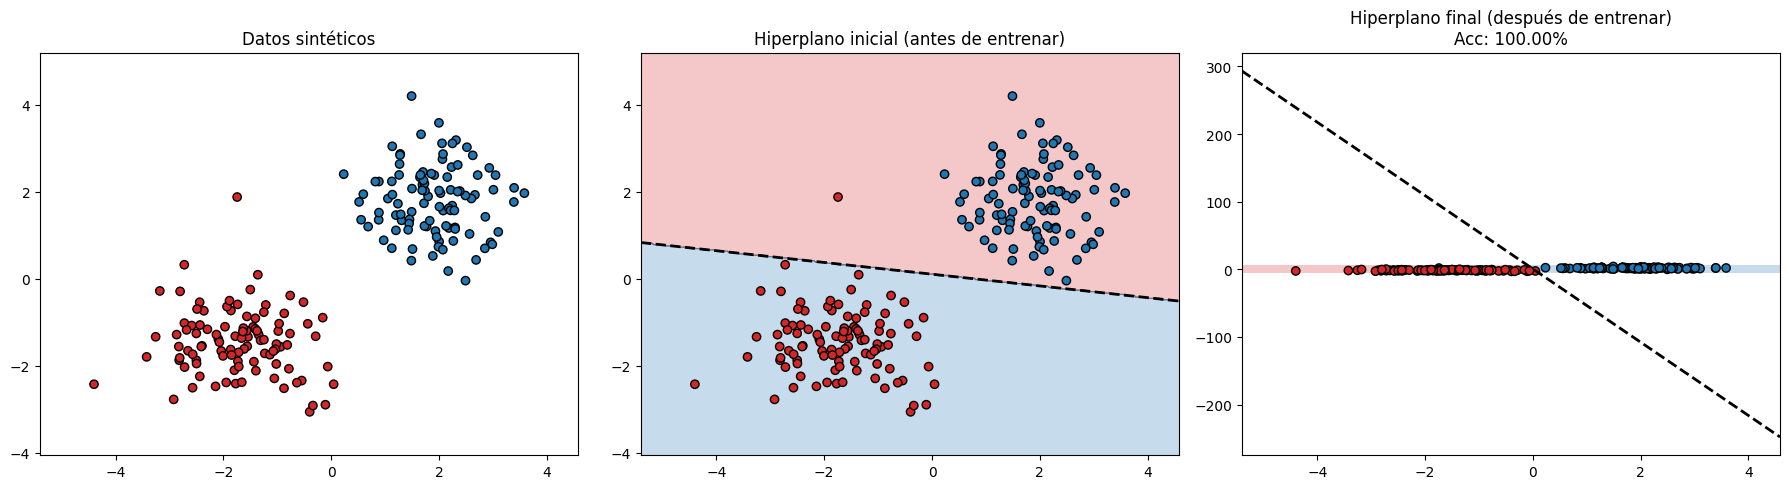

In [6]:
# 4. Visualización: Datos + Hiperplano inicial + Hiperplano final

def decision_region_from_wb(w, b, xx, yy):
    Z = np.where((xx * w[0] + yy * w[1] + b) >= 0, 1, -1)
    return Z

def plot_initial_final(X, y, initial_w, initial_b, final_w, final_b, acc, resolution=300):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    cmap = ListedColormap(['#d62728', '#1f77b4'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # --- (1) Datos originales ---
    axes[0].scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k')
    axes[0].set_title("Datos sintéticos")
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)

    # --- (2) Hiperplano inicial ---
    Z_init = decision_region_from_wb(initial_w, initial_b, xx, yy)
    axes[1].contourf(xx, yy, Z_init, alpha=0.25, cmap=cmap)
    axes[1].scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k')
    axes[1].set_title("Hiperplano inicial (antes de entrenar)")
    if initial_w[1] != 0:
        xs = np.array([x_min, x_max])
        ys = -(initial_w[0] * xs + initial_b) / initial_w[1]
        axes[1].plot(xs, ys, 'k--', linewidth=2)

    # --- (3) Hiperplano final ---
    Z_final = decision_region_from_wb(final_w, final_b, xx, yy)
    axes[2].contourf(xx, yy, Z_final, alpha=0.25, cmap=cmap)
    axes[2].scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k')
    axes[2].set_title(f"Hiperplano final (después de entrenar)\nAcc: {acc*100:.2f}%")
    if final_w[1] != 0:
        xs = np.array([x_min, x_max])
        ys = -(final_w[0] * xs + final_b) / final_w[1]
        axes[2].plot(xs, ys, 'k--', linewidth=2)

    plt.tight_layout()
    plt.show()

plot_initial_final(X, y, initial_w, initial_b, final_w, final_b, acc)

GIF guardado como: perceptron_evolucion.gif


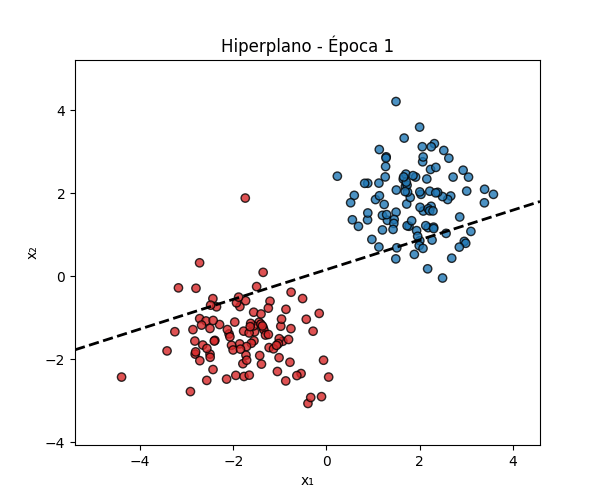

In [7]:
# 5. Función para animar la evolución del hiperplano

def animate_learning(model, X, y, filename="perceptron_evolucion.gif"):
    cmap = ListedColormap(['#d62728', '#1f77b4'])
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

    fig, ax = plt.subplots(figsize=(6,5))
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, edgecolors='k', alpha=0.8)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel("x₁")
    ax.set_ylabel("x₂")
    ax.set_title("Evolución del hiperplano (Perceptrón)")
    line, = ax.plot([], [], 'k--', linewidth=2)

    def update(frame):
        w = model.history_w[frame]
        b = model.history_b[frame]
        xs = np.array([x_min, x_max])
        ys = -(w[0] * xs + b) / w[1]
        line.set_data(xs, ys)
        ax.set_title(f"Hiperplano - Época {frame+1}")
        return line,

    ani = FuncAnimation(fig, update, frames=len(model.history_w), blit=True)
    ani.save(filename, writer=PillowWriter(fps=3))
    plt.close(fig)
    print(f"GIF guardado como: {filename}")

animate_learning(perceptron, X, y)
Image(filename='./perceptron_evolucion.gif')

### 9.3 Limitaciones del Perceptrón

El Perceptrón fue uno de los primeros algoritmos de aprendizaje supervisado inspirados en el cerebro (Rosenblatt, 1958).
Su impacto inicial fue enorme: demostraba que una máquina podía **“aprender” a clasificar patrones**.
Sin embargo, su estructura simple y su regla de actualización basada en un hiperplano lineal también impusieron **fuertes restricciones**.

#### **Principales limitaciones**

1. No puede resolver problemas no linealmente separables:

El Perceptrón solo puede encontrar **una frontera lineal** (una recta en 2D, un plano en 3D o un hiperplano en dimensiones mayores).
Por tanto, **fallará en problemas donde las clases estén entremezcladas de forma no lineal**.

*Ejemplo clásico:* el problema lógico **XOR**, donde no existe un hiperplano que separe perfectamente las clases.

$$
\text{XOR}(x_1, x_2) =
\begin{cases}
1, & \text{si } x_1 \neq x_2 \\
0, & \text{si } x_1 = x_2 \\
\end{cases}
$$

2. Convergencia garantizada solo si los datos son linealmente separables

El algoritmo de aprendizaje del Perceptrón **garantiza convergencia en un número finito de pasos solo cuando existe un hiperplano separador perfecto**.
En caso contrario, los pesos **oscilan indefinidamente** o se detienen sin encontrar una solución óptima.

3. No proporciona una medida probabilística ni una función de pérdida diferenciable

El Perceptrón **no produce una salida continua o probabilística** (solo valores +1 o −1).
Esto impide:

* Utilizar métodos de optimización basados en derivadas (como gradiente descendente continuo).
* Interpretar las salidas en términos de “confianza” o probabilidad.

4. Sensible a la escala y normalización de los datos

Dado que la frontera depende directamente de los valores de entrada, el Perceptrón puede comportarse mal si los atributos tienen escalas muy distintas.
→ Requiere **normalización previa** de las características.

5. Sin capacidad de representación jerárquica

El Perceptrón simple tiene **una sola capa de decisión lineal**.
No puede aprender **representaciones intermedias** o **características abstractas** de los datos, lo que limita su poder expresivo.

#### **Rendimiento de un perceptrón a un problema del tipo no lineal**

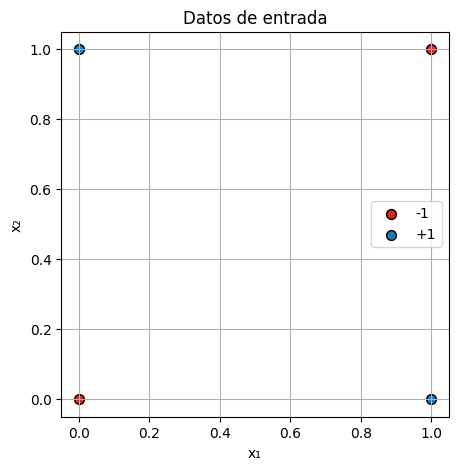

In [8]:
# 1. Datos no linealmente separables

# OPCIÓN A: XOR clásico
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([-1, 1, 1, -1])

# OPCIÓN B: datos no lineales
#X, y = make_moons(n_samples=200, noise=0.2, random_state=1)
#y = 2*y - 1

def plot_dataset(X, y, title="Datos de entrada"):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[y == -1, 0], X[y == -1, 1],
                c="#d62728", edgecolors='k', label="-1", s=50)
    plt.scatter(X[y == +1, 0], X[y == +1, 1],
                c="#1f77b4", edgecolors='k', label="+1", s=50)
    plt.title(title)
    plt.xlabel("x₁"); plt.ylabel("x₂")
    plt.legend(); plt.grid(True)
    plt.show()

plot_dataset(X, y)

In [9]:
# 2. Entrenamiento

model = Perceptron(n_features=2, lr=0.1, n_epochs=30, random_state=1)
model.fit(X, y)

print("Pesos finales:", model.w)
print("Sesgo:", model.b)
print("Errores por época:", model.loss_history)

Pesos finales: [0.13404401 0.04064899]
Sesgo: 0.0002287496346896345
Errores por época: [2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 4, 3, 3, 2, 2, 4, 3, 2, 4, 2, 4, 3, 2, 2, 2, 2, 2]


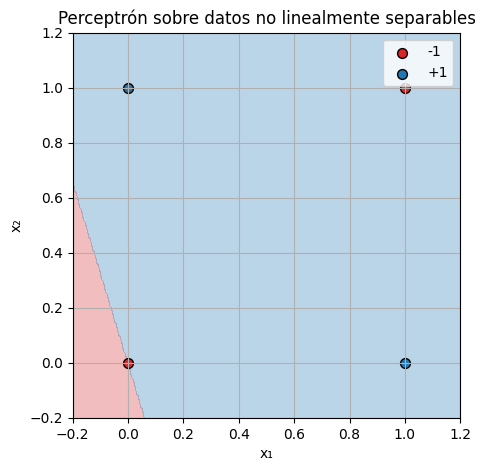

In [10]:
# 3. Frontera de decisión (si existiera)

def plot_decision_boundary(model, X, y, title="Frontera de decisión"):
    # margen dinámico del 20 %
    pad = 0.2
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    Z = np.array([model.predict(g) for g in grid]).reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf],
                 colors=["#d62728", "#1f77b4"], alpha=0.3)
    plt.scatter(X[y == -1, 0], X[y == -1, 1],
                c="#d62728", edgecolors='k', label="-1", s=50)
    plt.scatter(X[y == +1, 0], X[y == +1, 1],
                c="#1f77b4", edgecolors='k', label="+1", s=50)
    plt.title(title)
    plt.xlabel("x₁"); plt.ylabel("x₂")
    plt.legend(); plt.grid(True)
    plt.show()

plot_decision_boundary(model, X, y,
                       title="Perceptrón sobre datos no linealmente separables")

### 9.4 Perceptrón Multicapa (MLP)

#### Concepto general

Un **Perceptrón Multicapa (MLP)** es una red neuronal **feedforward**, compuesta por:

* Una **capa de entrada** (con $n$ neuronas, una por característica),
* Una o más **capas ocultas**, y
* Una **capa de salida**.

Cada capa realiza una transformación **afín + no lineal**:

$$
\mathbf{z}^{(l)} = \mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}
$$
$$
\mathbf{a}^{(l)} = f(\mathbf{z}^{(l)})
$$

donde:

* $\mathbf{a}^{(0)} = \mathbf{x}$: entrada del modelo,
* $f(\cdot)$: función de activación (sigmoide, tanh, ReLU, etc.),
* $\mathbf{W}^{(l)}$: pesos entre capa $l-1$ y capa $l$,
* $\mathbf{b}^{(l)}$: sesgos de la capa $l$.

El resultado final:
$$
\hat{y} = f_{\text{out}}(\mathbf{W}^{(L)} \mathbf{a}^{(L-1)} + \mathbf{b}^{(L)})
$$

#### Función de activación

La función de activación introduce **no linealidad**, permitiendo que el modelo aprenda fronteras complejas.

#### Propagación hacia adelante (forward pass)

Para una red con **una capa oculta**, el proceso es:

$$
h = f(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)
$$
$$
\hat{y} = g(\mathbf{W}_2 h + \mathbf{b}_2)
$$

donde $f$ y $g$ son funciones de activación (típicamente ReLU y sigmoide).

#### 1.4.4. Retropropagación del error (backpropagation)

El **entrenamiento del perceptrón multicapa (MLP)** consiste en minimizar una función de pérdida $L(y, \hat{y})$ ajustando los pesos mediante **descenso de gradiente**.
El gradiente de la pérdida con respecto a los pesos de la capa $l$ es:

$$
\frac{\partial L}{\partial W^{(l)}} = \delta^{(l)} (a^{(l-1)})^T
$$

donde:

* $W^{(l)}$: matriz de pesos de la capa $l$.
* $a^{(l-1)}$: vector de activaciones de la capa anterior.
* $\delta^{(l)}$: vector de errores locales o *deltas*.

Las deltas se calculan **de forma recursiva** desde la última capa hacia atrás:

$$
\delta^{(L)} = (\hat{y} - y) \odot f'(z^{(L)})
$$

$$
\delta^{(l)} = \left( W^{(l+1)} \right)^T \delta^{(l+1)} \odot f'(z^{(l)})
$$

donde:

* $z^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)}$ es la entrada neta de la capa $l$.
* $f'(z^{(l)})$ es la derivada de la función de activación.
* $\odot$ representa el **producto de Hadamard** (multiplicación elemento a elemento).

Este procedimiento propaga el error hacia atrás y ajusta los pesos capa por capa, permitiendo que el modelo **aprenda representaciones jerárquicas y no lineales**.

#### **Implementación en NumPy de un MLP**

In [11]:
# 1. Datos XOR

X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
y = np.array([[0], [1], [1], [0]])  # XOR binario (salida entre 0 y 1)

In [12]:
# 2. Inicialización

np.random.seed(42)
n_input, n_hidden, n_output = 2, 2, 1
W1 = np.random.randn(n_input, n_hidden)
b1 = np.zeros((1, n_hidden))
W2 = np.random.randn(n_hidden, n_output)
b2 = np.zeros((1, n_output))

In [13]:
# 3. Funciones de activación

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [14]:
# 4. Entrenamiento (backprop)

lr = 0.5
epochs = 10000
losses = []

for epoch in range(epochs):
    # Forward
    z1 = X @ W1 + b1
    a1 = sigmoid(z1)
    z2 = a1 @ W2 + b2
    y_hat = sigmoid(z2)

    # Error
    loss = np.mean((y - y_hat)**2)
    losses.append(loss)

    # Backward
    dL_dy = 2 * (y_hat - y)
    dL_dz2 = dL_dy * sigmoid_deriv(z2)
    dL_dW2 = a1.T @ dL_dz2
    dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)

    dL_da1 = dL_dz2 @ W2.T
    dL_dz1 = dL_da1 * sigmoid_deriv(z1)
    dL_dW1 = X.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

    # Actualización de pesos
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2

Predicciones finales:
[[0.011]
 [0.5  ]
 [0.989]
 [0.5  ]]
Pérdida final: 0.12518395984667333


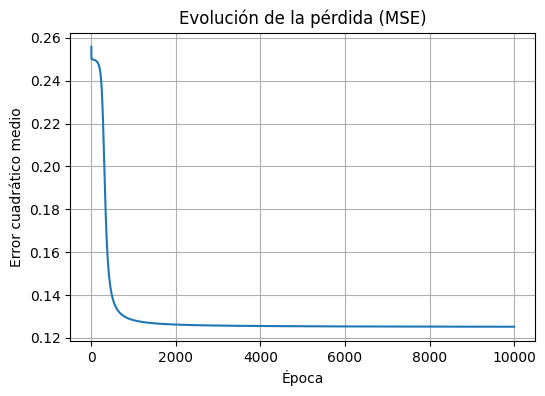

In [15]:
# 5. Resultados finales

print("Predicciones finales:")
print(np.round(y_hat, 3))
print("Pérdida final:", losses[-1])

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Evolución de la pérdida (MSE)")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio")
plt.grid(True)
plt.show()

## Redes densas

### 10.1 Concepto general

Una **red densamente conectada**, también llamada **Fully Connected Layer (FC Layer)** o **Dense Layer**, es aquella en la que **cada neurona de una capa está conectada con todas las neuronas de la capa siguiente**.

Matemáticamente, una capa totalmente conectada se define como:

$$
z^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)}
$$

$$
a^{(l)} = f(z^{(l)})
$$

donde:

* $W^{(l)} \in \mathbb{R}^{n_l \times n_{l-1}}$: matriz de pesos.
* $b^{(l)} \in \mathbb{R}^{n_l}$: vector de sesgos (*bias*).
* $a^{(l-1)}$: vector de activaciones de la capa anterior.
* $f(\cdot)$: función de activación (p. ej. ReLU, sigmoid, tanh).

Estas capas son la **base de las redes neuronales feedforward** y permiten aprender funciones no lineales complejas mediante la composición de transformaciones lineales y activaciones.

#### **Implementación en PyTorch de un red densa**

En PyTorch, una capa densa se implementa con `torch.nn.Linear`, que aplica la transformación lineal:

$$
\text{output} = xW^T + b
$$

In [16]:
# Definir una red simple con dos capas densas
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, output_dim=1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Capa oculta
        self.fc2 = nn.Linear(hidden_dim, output_dim) # Capa de salida

    def forward(self, x):
        x = F.relu(self.fc1(x))   # Activación no lineal ReLU
        x = torch.sigmoid(self.fc2(x))  # Salida entre 0 y 1
        return x

# Crear una instancia del modelo y probarlo
model = SimpleMLP(input_dim=2)
x = torch.randn(5, 2)  # 5 muestras, 2 características
y_pred = model(x)

print("Entrada:\n", x)
print("Salida del modelo:\n", y_pred)

Entrada:
 tensor([[-1.3228,  0.7089],
        [-0.2445,  1.2106],
        [-0.3454,  2.2272],
        [-0.7872, -0.4595],
        [ 0.1991,  0.4198]])
Salida del modelo:
 tensor([[0.3023],
        [0.4089],
        [0.3906],
        [0.3613],
        [0.4292]], grad_fn=<SigmoidBackward0>)


En una **Fully Connected Layer**, todas las neuronas de una capa se comunican con todas las de la siguiente, lo que **maximiza la capacidad de representación**, pero también:

* Aumenta el número de parámetros (( W ) y ( b )).
* Incrementa el costo computacional y el riesgo de sobreajuste (*overfitting*).

Por eso, en visión por computador se usan con moderación — principalmente al final de redes convolucionales (como en **clasificación**).

#### **Papel de las Funciones de activación no lineales**

Las **funciones de activación** introducen *no linealidad* en una red neuronal, permitiendo que aprenda relaciones complejas entre entrada y salida.
Sin activaciones no lineales, una red de múltiples capas sería equivalente a una sola transformación lineal.

Definición general

Dada una entrada $z^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)}$,
la activación se define como:

$$
a^{(l)} = f(z^{(l)})
$$

donde $f(\cdot)$ es una función no lineal aplicada elemento a elemento.

Funciones comunes**

| Función        | Expresión                       | Rango   | Derivada                                                         | Comentario                                               |
| -------------- | ------------------------------- | ------- | ---------------------------------------------------------------- | -------------------------------------------------------- |
| **Sigmoide**   | ( f(z) = \frac{1}{1 + e^{-z}} ) | (0, 1)  | ( f'(z) = f(z)(1 - f(z)) )                                       | Suaviza la salida, usada en clasificación binaria        |
| **Tanh**       | ( f(z) = \tanh(z) )             | (-1, 1) | ( f'(z) = 1 - \tanh^2(z) )                                       | Centra la salida alrededor de 0                          |
| **ReLU**       | ( f(z) = \max(0, z) )           | [0, ∞)  | ( f'(z) = \begin{cases} 1 & z > 0 \ 0 & z \le 0 \end{cases} )    | Computacionalmente eficiente y evita saturación positiva |
| **Leaky ReLU** | ( f(z) = \max(0.01z, z) )       | (-∞, ∞) | ( f'(z) = \begin{cases} 1 & z > 0 \ 0.01 & z \le 0 \end{cases} ) | Soluciona neuronas muertas de ReLU                       |

Visualización en PyTorch

Este código genera las curvas de activación y sus derivadas para **Sigmoid**, **Tanh** y **ReLU**.

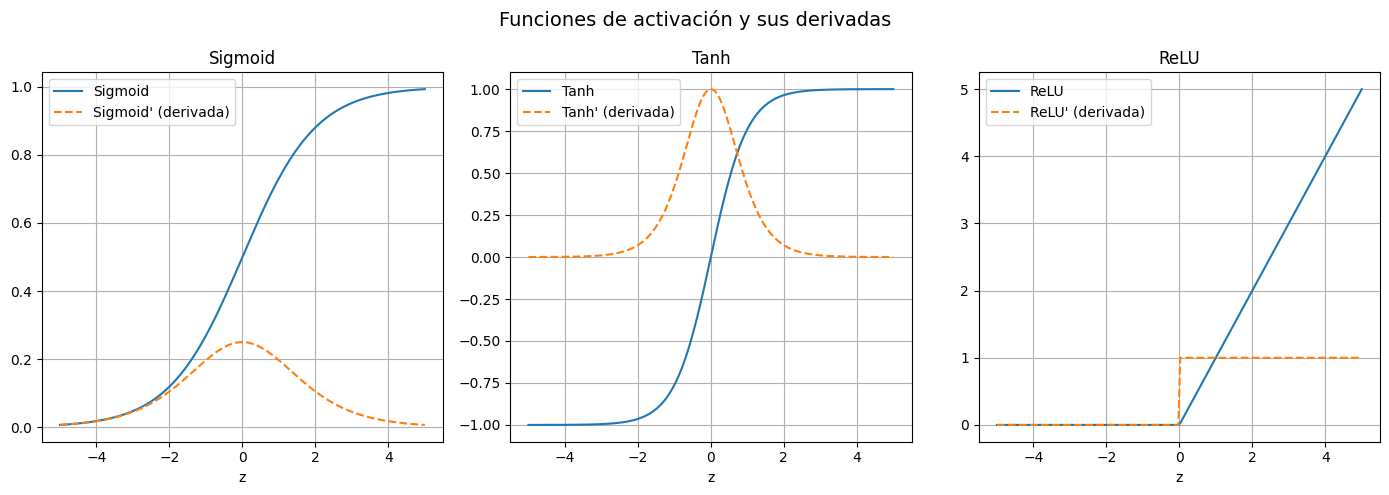

In [17]:
# Rango de valores
z = torch.linspace(-5, 5, 200)

# Funciones de activación
sigmoid = torch.sigmoid(z)
tanh = torch.tanh(z)
relu = F.relu(z)

# Derivadas aproximadas (usando gradientes automáticos)
z.requires_grad_(True)
f_list = [torch.sigmoid(z), torch.tanh(z), F.relu(z)]
names = ['Sigmoid', 'Tanh', 'ReLU']
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(14, 5))

for i, f in enumerate(f_list):
    plt.subplot(1, 3, i+1)
    f.backward(torch.ones_like(z), retain_graph=True)
    plt.plot(z.detach().numpy(), f.detach().numpy(), label=f'{names[i]}')
    plt.plot(z.detach().numpy(), z.grad.numpy(), '--', label=f"{names[i]}' (derivada)")
    z.grad.zero_()
    plt.title(names[i])
    plt.xlabel("z")
    plt.legend()
    plt.grid(True)

plt.suptitle("Funciones de activación y sus derivadas", fontsize=14)
plt.tight_layout()
plt.show()

Cada función tiene ventajas y desventajas:

* **Sigmoid / Tanh**: útiles para tareas donde la salida requiere una cota, pero pueden causar **gradientes muy pequeños** (*vanishing gradients*).
* **ReLU y variantes**: preferidas en la práctica por su eficiencia y capacidad para mantener gradientes más estables.
* En redes profundas, la elección de la activación puede afectar drásticamente la **velocidad de convergencia** y la **capacidad de generalización**.

### 10.2 Entrenamiento

El entrenamiento de una red neuronal consiste en **ajustar los pesos $W$ y sesgos $b$** para minimizar una función de pérdida, usando un algoritmo de optimización iterativo.

#### Función de pérdida

La **función de pérdida (Loss Function)** mide la discrepancia entre la salida predicha $\hat{y}$ y la etiqueta real $y$.
Su elección depende del tipo de problema.

**Regresión** – *Error cuadrático medio (MSE)*

$$
\mathcal{L}*{\text{MSE}} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

**Clasificación** – *Entropía cruzada (Cross-Entropy)*

Para una muestra y una red con salida softmax:

$$
\mathcal{L}*{\text{CE}} = - \sum_{c=1}^{C} y_c \log(\hat{y}_c)
$$

donde:

* $y_c$ es la etiqueta (1 si pertenece a la clase $c$, 0 en caso contrario),
* $\hat{y}_c = \frac{e^{z_c}}{\sum_j e^{z_j}}$ es la probabilidad estimada por la red.

#### Descenso de gradiente

El objetivo es minimizar la pérdida actualizando los pesos en la dirección opuesta al gradiente:

$$
W \leftarrow W - \eta , \frac{\partial \mathcal{L}}{\partial W}
$$

donde:

* $\eta$ es la **tasa de aprendizaje (learning rate)**,
* $\frac{\partial \mathcal{L}}{\partial W}$ es el gradiente de la pérdida respecto a los pesos.

Tipos de descenso:

| Tipo                                  | Descripción                                                                    |
| ------------------------------------- | ------------------------------------------------------------------------------ |
| **Batch Gradient Descent**            | Usa todo el conjunto de entrenamiento por iteración (más estable, pero lento). |
| **Stochastic Gradient Descent (SGD)** | Actualiza los pesos muestra por muestra (rápido pero ruidoso).                 |
| **Mini-Batch Gradient Descent**       | Compromiso entre ambos, más común en práctica.                                 |

#### Optimizadores en PyTorch

PyTorch implementa variantes modernas que ajustan automáticamente los gradientes:

| Optimizador | Idea principal                                          | Ecuación simplificada                                         |
| ----------- | ------------------------------------------------------- | ------------------------------------------------------------- |
| **SGD**     | Paso fijo en dirección del gradiente                    | ( W \leftarrow W - \eta \nabla_W \mathcal{L} )                |
| **Adam**    | Acumula promedios móviles de gradientes y sus cuadrados | ( W \leftarrow W - \frac{\eta , m_t}{\sqrt{v_t} + \epsilon} ) |

#### Hiperparámetros de entrenamiento

| Parámetro           | Significado                          | Efecto                                               |
| ------------------- | ------------------------------------ | ---------------------------------------------------- |
| **Épocas (epochs)** | Número de pasadas por el dataset     | Muy alto → sobreajuste (*overfitting*)               |
| **Batch size**      | Número de muestras por actualización | Mayor → gradiente más estable                        |
| **Learning rate**   | Magnitud del paso del optimizador    | Muy alto → divergencia; muy bajo → aprendizaje lento |

#### Overfitting y regularización

Cuando una red **memoriza** los datos de entrenamiento y pierde capacidad de generalización.

**Síntomas:**

* Alta precisión en entrenamiento, baja en validación.

**Soluciones:**

| Técnica                 | Descripción                                                | En PyTorch                     |
| ----------------------- | ---------------------------------------------------------- | ------------------------------ |
| **Dropout**             | Desactiva aleatoriamente neuronas durante el entrenamiento | `nn.Dropout(p=0.5)`            |
| **Weight Decay (L2)**   | Penaliza pesos grandes                                     | `Adam(..., weight_decay=1e-4)` |
| **Early Stopping**      | Detiene entrenamiento cuando no mejora validación          | Manual o con callbacks         |
| **Batch Normalization** | Normaliza activaciones por batch                           | `nn.BatchNorm1d()`             |

#### **Implementación de una MLP para clasificación en PyTorch**

In [18]:
# 1. Generación de datos

X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

In [19]:
# 2. Creación y definición de MLP, Función de costo y Optimizador

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )
    def forward(self, x):
        return self.net(x)

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [20]:
# 3. Entrenamiento

train_losses, val_losses = [], []
for epoch in range(100):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    # Validación
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val), y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

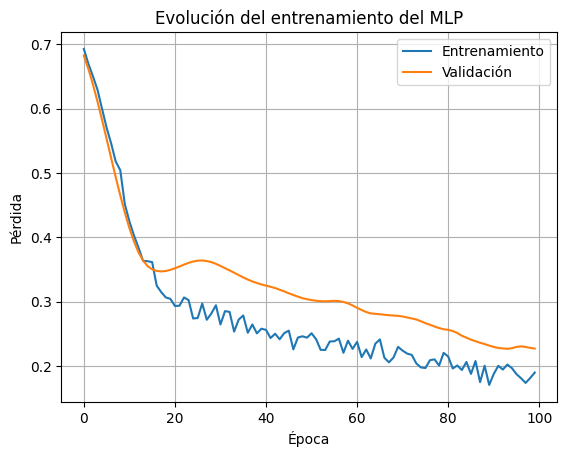

In [21]:
# 4.  Resultados finales

plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución del entrenamiento del MLP')
plt.grid(True)
plt.show()

### Ejemplo en un problema de visión

#### Dataset MNIST

* Imágenes: $28\times28$ píxeles en escala de grises
* 10 clases (dígitos del 0 al 9)
* Conjunto de entrenamiento: 60,000 imágenes
* Conjunto de prueba: 10,000 imágenes

#### **Implementación en PyTorch**

In [23]:
# 1. Carga de datos y preprocesado
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización a [-1, 1]
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [ ]:
# 2. Creación y definición de MLP, Función de costo y Optimizador

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
# 3. Entrenamiento

num_epochs = 10
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

start_train = time.time()          # tiempo total

for epoch in range(num_epochs):
    epoch_start = time.time()      # tiempo de esta época

    # ---------- TRAIN ----------
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(100 * correct / total)

    # ---------- EVAL ----------
    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_loss_hist.append(test_loss / len(test_loader))
    test_acc_hist.append(100 * correct / total)

    epoch_time = time.time() - epoch_start
    print(f"Época [{epoch+1}/{num_epochs}] - "
          f"Pérdida Entrenamiento: {train_loss_hist[-1]:.4f}, "
          f"Precisión Entrenamiento: {train_acc_hist[-1]:.2f}% | "
          f"Precisión Validación: {test_acc_hist[-1]:.2f}% | "
          f"Tiempo: {epoch_time:.2f}s")

total_time = time.time() - start_train
print(f"\nEntrenamiento finalizado en {total_time:.2f}s ({total_time/60:.1f} min)")

Época [1/10] - Pérdida Entrenamiento: 0.3955, Precisión Entrenamiento: 87.75% | Precisión Validación: 94.16% | Tiempo: 28.02s
Época [2/10] - Pérdida Entrenamiento: 0.2092, Precisión Entrenamiento: 93.53% | Precisión Validación: 95.80% | Tiempo: 22.60s
Época [3/10] - Pérdida Entrenamiento: 0.1697, Precisión Entrenamiento: 94.69% | Precisión Validación: 95.93% | Tiempo: 25.86s
Época [4/10] - Pérdida Entrenamiento: 0.1501, Precisión Entrenamiento: 95.20% | Precisión Validación: 96.67% | Tiempo: 28.25s
Época [5/10] - Pérdida Entrenamiento: 0.1397, Precisión Entrenamiento: 95.58% | Precisión Validación: 96.80% | Tiempo: 25.03s
Época [6/10] - Pérdida Entrenamiento: 0.1292, Precisión Entrenamiento: 95.86% | Precisión Validación: 96.80% | Tiempo: 21.62s
Época [7/10] - Pérdida Entrenamiento: 0.1210, Precisión Entrenamiento: 96.21% | Precisión Validación: 97.33% | Tiempo: 22.07s
Época [8/10] - Pérdida Entrenamiento: 0.1154, Precisión Entrenamiento: 96.33% | Precisión Validación: 96.87% | Tiempo:

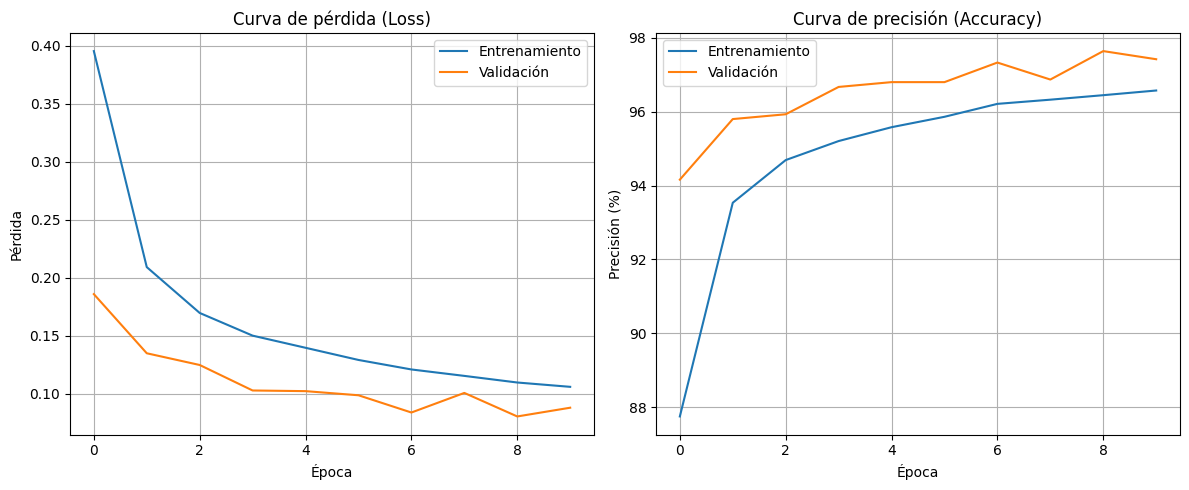

In [ ]:
# 4. Resultados finales

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(train_loss_hist, label='Entrenamiento')
axes[0].plot(test_loss_hist, label='Validación')
axes[0].set_title("Curva de pérdida (Loss)")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Pérdida")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_acc_hist, label='Entrenamiento')
axes[1].plot(test_acc_hist, label='Validación')
axes[1].set_title("Curva de precisión (Accuracy)")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("Precisión (%)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

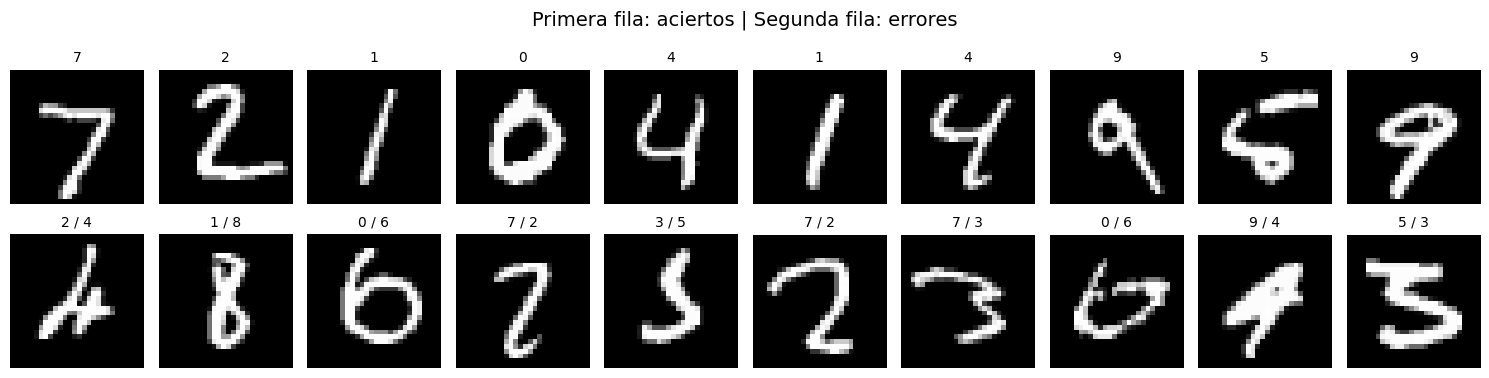

In [ ]:
# 5. Interpretación de errores

"""
Visualizamos ejemplos donde el modelo acierta (fila superior)
y donde falla (fila inferior) para analizar posibles causas.
"""

model.eval()
correct_images, correct_preds, correct_labels = [], [], []
wrong_images, wrong_preds, wrong_labels = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct_mask = preds == labels
        wrong_mask = preds != labels

        if correct_mask.any():
            correct_images.append(images[correct_mask])
            correct_preds.append(preds[correct_mask])
            correct_labels.append(labels[correct_mask])

        if wrong_mask.any():
            wrong_images.append(images[wrong_mask])
            wrong_preds.append(preds[wrong_mask])
            wrong_labels.append(labels[wrong_mask])

        # Romper cuando tengamos suficientes ejemplos
        if len(correct_images) > 2 and len(wrong_images) > 2:
            break

# Concatenar y limitar muestras
correct_images = torch.cat(correct_images)[:10].cpu()
correct_preds = torch.cat(correct_preds)[:10].cpu()
correct_labels = torch.cat(correct_labels)[:10].cpu()

wrong_images = torch.cat(wrong_images)[:10].cpu()
wrong_preds = torch.cat(wrong_preds)[:10].cpu()
wrong_labels = torch.cat(wrong_labels)[:10].cpu()

# Mostrar 2 filas: correctas (arriba) y erróneas (abajo)
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

# Casos correctos
for i, ax in enumerate(axes[0]):
    ax.imshow(correct_images[i].squeeze(), cmap="gray")
    ax.set_title(f"{correct_preds[i].item()}", fontsize=10)
    ax.axis("off")

# Casos erróneos
for i, ax in enumerate(axes[1]):
    ax.imshow(wrong_images[i].squeeze(), cmap="gray")
    ax.set_title(f"{wrong_preds[i].item()} / {wrong_labels[i].item()}", fontsize=10)
    ax.axis("off")

plt.suptitle("Primera fila: aciertos | Segunda fila: errores", fontsize=14)
plt.tight_layout()
plt.show()